# README：
As announced in Next'23, Biglake supported all the popular open formats, including ICEBERG, HUDI, Deltalake. Taking BQ native format into consideration, there are four lakehouse format supported by Bigquery. What's the difference between these fomats? how to choose which format to use? 

In this [deck](https://docs.google.com/presentation/d/1DhaU3n2LnkijVcV36WqNV6dlNiROEVnRZPBK0nOreFY/edit), we tried to explain the PROS and CONS of each individual format from <b>underpinning architecture</b> and <b>process framework</b> perspective. 

As for <b>performance</b>, we will show in this notebook the end2end process about how to setup performance test envrionment, prepare test data and query, analyze the performance data collected. 

We use [TPCDS](https://www.tpc.org/tpcds/), one of the most popular analytics performance test framework,for this test. 
There are two approaches to generate TPCDS data: traditional and spark. Both approaches are tried and documented in this notebook. 

---

# Option-1: Generate TPCDS using traditional package

## Step 1. Prepare TPCDS ENV
In this guide, VM is leveraged to run the TPCDS process and the VM setting is listed below: 
*  <b>OS:</b> CentOS Linux release 7.9.2009 (Core)
*  <b>Type:</b> n2-standard-16

<b>prerequisite</b>
*  Download the [tpcds packages](https://www.tpc.org/tpc_documents_current_versions/current_specifications5.asp) first. In this process, we downloaded package version 3.20 and copy it to GCS for the convenience sake. 
*  Dowload the [git pakcage](https://github.com/DigitalWNZ/gcp_python_code) which contains the following key components
    *  [Bigquery schema json](https://github.com/DigitalWNZ/gcp_python_code/tree/main/Bigquery_schema_json) - Table schema in json format used for building bigquery native table
    *  [Bigquery schema str](https://github.com/DigitalWNZ/gcp_python_code/tree/main/Bigquery_schema_str) - Table schema in str used for buidling iceberg table
    
    *  [Tpcds bigquery template](https://github.com/DigitalWNZ/gcp_python_code/tree/main/tpcds-bigquery-template) - Query template for bigquery which is used to generated query runnable on Bigquery. 
    *  [Generated query 320](https://github.com/DigitalWNZ/gcp_python_code/tree/main/generated_query_320) - Generated query adaptable to Bigquery
    *  [tpcds_query_execution.py](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_query_execution.py) - Python program to run queries and store the job information. 
    *  [tpcds_schema_trans_json2string.py](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_schema_trans_json2string.py) - Python programe to translate schema in json to string 
    
    *  [tpcds_gen_iceberg_no_par](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_gen_iceberg_no_par) - Pyspark program to generate Biglake iceberg table without partition
    *  [tpcds_gen_iceberg_with_par](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_gen_iceberg_with_par) - Pyspark program to generate Biglake iceberg table partitioned on data field

---
<b>Internal Reference</b>
*  [Bigquery TPCDS](https://docs.google.com/document/d/1iOR9Y7fEzU3198JJjYMolUav60RejGo9xGw6BNWApm8/edit)
*  [Bigquery schema](https://source.corp.google.com/piper///depot/google3/experimental/users/bchhay/tpcds/schema/)
*  [Bigquery query template](https://source.corp.google.com/piper///depot/google3/experimental/users/bchhay/tpcds/query_templates/)
*  [Bigquery query generation utils 1](https://source.corp.google.com/piper///depot/google3/experimental/users/bchhay/tpcds/generate_queries_function.sh)
*  [Bigquery query generation utils 2](https://source.corp.google.com/piper///depot/google3/experimental/users/bchhay/tpcds/generate_queries.sh)


In [11]:
%%bash
# Install prerequisite tools. 
sudo yum -y install unzip
sudo yum -y install gcc
sudo yum -y install make

# unzip and build the TPCDS Tools. Since I've uploaded the package to GCS in advance so I only copy it here. 
gsutil cp gs://agolis-allen-first-iceberg-tpcds/TPC-DS-Tool-320.zip .
unzip TPC-DS-Tool-320.zip
cd DSGen-software-code-3.2.0rc1/
cd tools/
make

## Step 2: Generate Data and Bigquery native tables
Run <b>DSDGEN</b> command to generate TPCDS data. 
*  [DSDGEN Reference](https://datacadamia.com/data/type/relation/benchmark/tpcds/dsdgen)
*  [Scale Factor Reference](https://www.tpc.org/TPC_Documents_Current_Versions/pdf/TPC-DS_v3.2.0.pdf#page=41&zoom=100,325,96)

When creating Bigquery native tables, It is necessary to provide the json schema which can be found at [Bigquery schema json](https://github.com/DigitalWNZ/gcp_python_code/tree/main/Bigquery_schema_json)

The generated data will stored in dataset <b>tpcds_data_320</b> which can be adjusted accordingly.

In [ ]:
# Build /tpcds directory to store the generated data. 
cd /
mkdir tpcds

# Generate data and stored in pre-build directory 
sudo ./dsdgen -scale 100 -dir /tpcds -parallel 10 -child 1

# Upload the data to GCS 
gsutil mb -l us-central1 gs://agolis-allen-first-iceberg-tpcds
gsutil -m cp /tpcds/*.dat gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/

# Load data to build Bigquery native table, replace the dataset name "tpcds_data_320" and schema json. 
bq --location=us-central1  mk --dataset --force=true agolis-allen-first:tpcds_data_320
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.call_center gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/call_center_1_10.dat ../Bigquery_schema/call_center.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.customer_demographics gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/customer_demographics_1_10.dat ../Bigquery_schema/customer_demographics.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.income_band gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/income_band_1_10.dat ../Bigquery_schema/income_band.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.ship_mode gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/ship_mode_1_10.dat ../Bigquery_schema/ship_mode.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.warehouse gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/warehouse_1_10.dat ../Bigquery_schema/warehouse.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.catalog_page gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/catalog_page_1_10.dat ../Bigquery_schema/catalog_page.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.customer gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/customer_1_10.dat ../Bigquery_schema/customer.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.inventory gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/inventory_1_10.dat ../Bigquery_schema/inventory.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.store gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/store_1_10.dat ../Bigquery_schema/store.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.web_page gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/web_page_1_10.dat ../Bigquery_schema/web_page.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.catalog_returns gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/catalog_returns_1_10.dat ../Bigquery_schema/catalog_returns.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.date_dim gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/date_dim_1_10.dat ../Bigquery_schema/date_dim.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.item gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/item_1_10.dat ../Bigquery_schema/item.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.store_returns gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/store_returns_1_10.dat ../Bigquery_schema/store_returns.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.web_returns gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/web_returns_1_10.dat ../Bigquery_schema/web_returns.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.catalog_sales gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/catalog_sales_1_10.dat ../Bigquery_schema/catalog_sales.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.promotion gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/promotion_1_10.dat ../Bigquery_schema/promotion.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.store_sales gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/store_sales_1_10.dat ../Bigquery_schema/store_sales.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.web_sales gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/web_sales_1_10.dat ../Bigquery_schema/web_sales.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.customer_address gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/customer_address_1_10.dat ../Bigquery_schema/customer_address.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.household_demographics gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/household_demographics_1_10.dat ../Bigquery_schema/household_demographics.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.reason gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/reason_1_10.dat ../Bigquery_schema/reason.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.time_dim gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/time_dim_1_10.dat ../Bigquery_schema/time_dim.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.web_site gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/web_site_1_10.dat ../Bigquery_schema/web_site.json
bq load --field_delimiter='|' --source_format=CSV --quote='' --ignore_unknown_values tpcds_data_320.dbgen_version gs://agolis-allen-first-iceberg-tpcds/tpcds_320_data/dbgen_version_1_10.dat ../Bigquery_schema/dbgen_version.json

## Step 3: Generate iceberg table and create Biglake icerberg tables
After the data has been loaded into Bigquery native table, we can run following two pyspark jobs directly in Bigquery to generate ICEBERG data on GCS and build biglake iceberg table. 
*  [tpcds_gen_iceberg_no_par](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_gen_iceberg_no_par) - Pyspark program to generate Biglake iceberg table without partition
*  [tpcds_gen_iceberg_with_par](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_gen_iceberg_with_par) - Pyspark program to generate Biglake iceberg table partitioned on data field

When creating iceberg table, schema should be inputted in "(name stribg, age integer,....)" format which can be found at [Bigquery schema str](https://github.com/DigitalWNZ/gcp_python_code/tree/main/Bigquery_schema_str), It is generated from the [Bigquery json schema](https://github.com/DigitalWNZ/gcp_python_code/tree/main/Bigquery_schema_json) using this tool [tpcds_schema_trans_json2string.py](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_schema_trans_json2string.py) 

The generated data will be stored in two datasets <b>tpcds_data_320_iceberg_no_par</b> and <b>tpcds_data_320_iceberg_with_par</b> by default, users can adjust the dataset name accordingly. 

In [9]:
# 1. Create connection for calling spark procedure
bq mk --connection --connection_type='SPARK' --project_id=agolis-allen-first --location=us-central1 spark-conn-tpcds

# 2. Create connection for creating biglake tables
bq mk --connection --connection_type='CLOUD_RESOURCE' --project_id=agolis-allen-first --location=us-central1 biglake

# 3. grant bigquery admin, storage admin, biglake admin to the SA attached to the connections. 

# 4. create dataset to host biglake icerberg table
bq --location=us-central1  mk --dataset --force=true agolis-allen-first:tpcds_data_320_iceberg_with_par
bq --location=us-central1  mk --dataset --force=true agolis-allen-first:tpcds_data_320_iceberg_no_par

# 5. run spark procedure in Bigquery to create biglake tables.  In the procedure, the schema is translated from Bigquery json format schema using program. 

## Step 4: Generate query
*  Run <b>DSQGEN</b> command to generate the query. Since TPCDS does not provide native Bigquery SQL, so we need to replace  <b>TPCDS native query templates</b>  with <b>[Bigquery template](https://github.com/DigitalWNZ/gcp_python_code/tree/main/tpcds-bigquery-template)</b> which supports native bigquery syntax.  
*  If you don't want to generate the query, you can also use the [query](https://github.com/DigitalWNZ/gcp_python_code/tree/main/generated_query_320) which has been generated already and is available to Bigquery

In [ ]:
cd DSGen-software-code-3.2.0rc1/

# make to directory to store the generated query. 
rm -rf generated_query
mkdir generated_query

#[Option-1]replace the shipped query template with a template which support native bigquery query syntax. 
gsutil -m cp -r gs://agolis-allen-first-iceberg-tpcds/tpcds-bigquery-template .
mv query_templates query_templates_orig
mv tpcds-bigquery-template query_templates
#[Option-2] Since users can specify which query template to use when running DSQGEN command, users can simply copy the template and specify this template in DSQGEN command. 
gsutil -m cp -r gs://agolis-allen-first-iceberg-tpcds/tpcds-bigquery-template .

# Each DSQGEN execution generates the file "query_0.sql" in the target directory and the file will be overwritten by next execution, so move it to its final name.  
for (( i=1; i<=99; i++ ));do query_template="$i.tpl";echo "Running dsqgen... Query: $i of 99";./dsqgen -template $query_template -directory ../query_template -dialect ansi -scale 100 -output_dir ../generated_query;mv ../generated_query/query_0.sql ../generated_query/$i.sql;done
queries_with_iterations=("14" "23" "24" "39")
queries_with_iterations_length=${#queries_with_iterations[@]}
for (( i=0; i<${queries_with_iterations_length}; i++ ));do query_template="${queries_with_iterations[$i]}b.tpl";  echo "Running dsqgen... Query with iteration: ${queries_with_iterations[$i]} of [${queries_with_iterations[@]}]"; ./dsqgen -template $query_template -directory ../query_template -dialect ansi -scale 100 -output_dir ../generated_query ; mv ../generated_query/query_0.sql ../generated_query/${queries_with_iterations[$i]}b.sql; done

## Step 5: Validate query

To facilitate query execution and performance data collection, we make a <b>[queryexecution controller program](https://github.com/DigitalWNZ/gcp_python_code/blob/main/tpcds_query_execution.py) </b> which can validate query, run query and collect performance data

Here is the key parameters users need to specify before run the program. 
<ol>
<li><b>default_project</b> -- the GCP project which contains the Bigquery/Biglake iceberg datasets. </li>
<li><b>default_dataset</b> -- the Bigquery datasets which contains the Bigquery/Biglake tables.</li> 
<li><b>region</b> -- The region of Bigquery/Biglake datasets.</li>

<li><b>result_project,result_dataset,result_table</b> -- The full path to Bigquery tables which stores the performance data collected from this program execution.</li>
<li><b>cross_result_table</b>  -- The program execution will be joined with INFORMATION_SCHEMA data to present a holitic view of the execution, The comprehensive data will be stored in table {result_project}.{result_dataset}.{cross_result_table}</li>

<li><b>run_id</b> -- Unique ID to identify each individual program execution.</li>
<li><b>query_category</b> -- Description of each individual program execution, it's recommended to use this parameter to mark what data to query, such as 'Bigquery Native','Bigquery icerberg no partition','Bigquery icerberg with partition','Bigquery Native CMeta'.</li>
<li><b>query_run_times</b> -- The number of each individual query's execution. </li>
<li><b>dry_run_flag</b> -- Control the query execution mode of each program run</li>
    -  <b>False</b> -- Query will be executed and performance data will be collected<br>
    -  <b>True</b> -- Query will run in Dry_run mode and no data will be collected. it's used for query validation
</ol>

In this step, set <b>dry_run_flag=True, query_run_times = 1</b> to validate the query. 

## Step 6. Run generated queries
Set the parameter accordingly to run the controller program and result is saved to {result_project}.{result_dataset}.{result_table}/{cross_result_table}

# Step 7. Analyze the performance result. 
We run the controller program 4 times on Bigquery native table, Biglake iceberg tables without partition, Biglake icerberg tables with partion and Bigquery native table with CMeta enabled.

In [18]:
import os
import pandas as pd
import plotly.express as px
from google.cloud import bigquery

import matplotlib.pyplot as plt
%matplotlib inline

Project_id='agolis-allen-first'
client = bigquery.Client(Project_id)

query = f"""
SELECT category, exp(avg(log(avg_slots))) as slot,exp(avg(log(job_duraiton))) as duration, exp(avg(log(total_bytes_processed))) as bytes FROM `agolis-allen-first.tpcds_data_320.tpcds_cross_result`  group by 1
union all
SELECT category, exp(avg(log(avg_slots))) as slot,exp(avg(log(job_duraiton))) as duration, exp(avg(log(total_bytes_processed))) as bytes  FROM `agolis-allen-first.tpcds_data_320.tpcds_cross_result_cmeta` group by 1
union all
SELECT category, exp(avg(log(avg_slots))) as slot,exp(avg(log(job_duraiton))) as duration, exp(avg(log(total_bytes_processed))) as bytes  FROM `agolis-allen-first.tpcds_data_320_iceberg_no_par.tpcds_cross_result` group by 1
union all
SELECT category, exp(avg(log(avg_slots))) as slot,exp(avg(log(job_duraiton))) as duration, exp(avg(log(total_bytes_processed))) as bytes  FROM `agolis-allen-first.tpcds_data_320_iceberg_with_par.tpcds_cross_result` group by 1;
"""
job_config = bigquery.job.QueryJobConfig(use_query_cache=True)
query_job = client.query(query,job_config=job_config)
result_df = query_job.to_dataframe()

result_df

,category,slot,duration,bytes
0,Bigquery Native,38.444397,1237.185603,7.702637e+08
1,Bigquery icerberg no partition Native,49.552694,2357.965053,8.780093e+08
2,Bigquery icerberg with partition,237.055181,2653.493916,8.782039e+08
3,Bigquery Native CMeta,19.407814,1109.209629,7.702637e+08


In [27]:
result_df['bytes']=result_df['bytes']/(1024*1024)
result_df_T = result_df.set_index('category').T.reset_index()
result_df_T

category,index,Bigquery Native,Bigquery icerberg no partition Native,Bigquery icerberg with partition,Bigquery Native CMeta
0,slot,38.444397,49.552694,237.055181,19.407814
1,duration,1237.185603,2357.965053,2653.493916,1109.209629
2,bytes,734.580672,837.334944,837.520464,734.580672


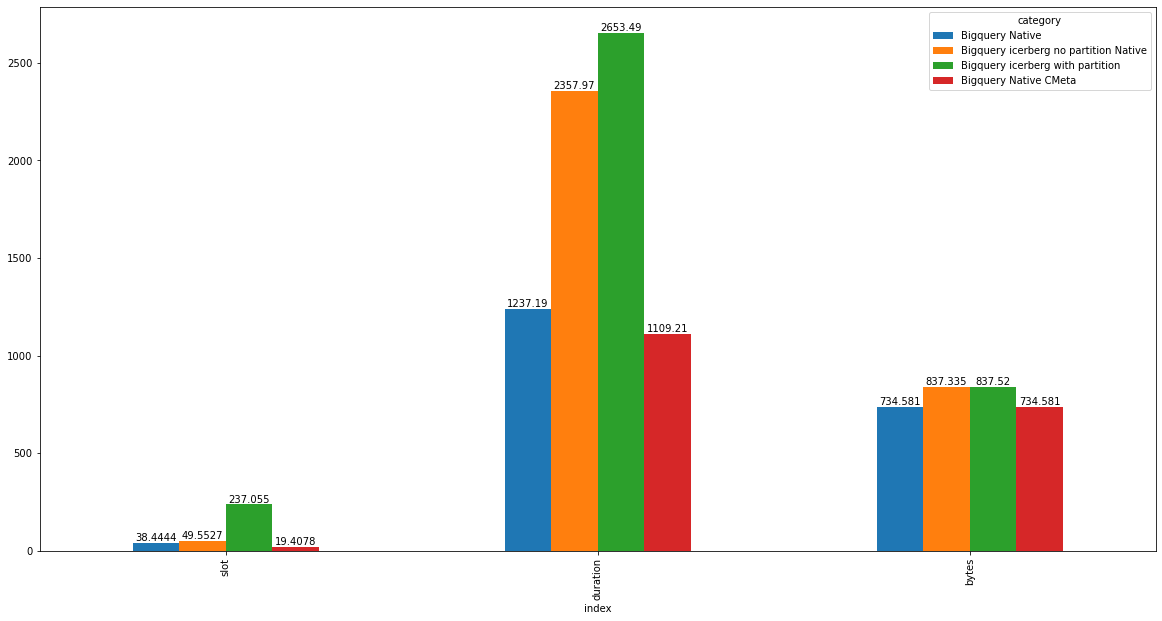

In [28]:
fig, ax = plt.subplots(figsize=(20,10)) 
result_df_T.plot(x = "index", y = ["Bigquery Native","Bigquery icerberg no partition Native","Bigquery icerberg with partition","Bigquery Native CMeta"], secondary_y = "bytes", ax = ax,kind='bar') 
for container in ax.containers:
    ax.bar_label(container)

# Findings 
*  <b>Cmeta matter</b> --  if we only look at "Bigquery Native" and "Bigquery Native Cmeta", it's quite obvious Cmeta can dramatically reduct slot usage which is doule-sharp sword, reduce query response time. 
    *  <b>Remaining question</b> 
        *  Why bytes was not redued? 

*  <b>Biglake tables less performant than native table</b> -- Biglake tables consumes more slot while takes longer duration compared with Bigquery native tables.
    *  <b>Remaining question</b> 
        *  Why Iceberg with partition takes more slot and longer duration than no partition
        *  Why Iceberg with partition does not reduct bytes scanned?  the data volume is too small? will try larger scale factor later. 
---

# Option-2:  generate TPCDS data using spark
It's also possible to generate TPCDS data in spark ecosystem which has been decribed in [Forrest Document](https://docs.google.com/document/d/1cEORejAHMBN_151IeYR8x3GfEk_VxrB5azdcpPOqsUU/edit?resourcekey=0-_m1Bir1x9ne3UEC_k4XZjQ) and [Github](https://github.com/gddezero/gcp-samples/tree/main/tpcds_dataproc). 

This process is alos tried and documented below. However, we met some questions which may need further investigation. 


## Step 1.Create dataproc cluster to generate TPCDS data on GCS

In [1]:
%%bash
export CLUSTER_NAME=tpcds-cluster
export PROJECT=agolis-allen-first
export REGION=us-central1
export NETWORK=first-vpc
export SUBNET=first-vpc
export DATAPROC_BUCKET=agolis-allen-first-iceberg-tpcds
export DW_BUCKET=agolis-allen-first-iceberg-tpcds
export DPMS_NAME=hms
gcloud config set project ${PROJECT}

gcloud metastore services create ${DPMS_NAME} \
  --location=${REGION} \
  --hive-metastore-version=3.1.2 \
  --tier=developer \
  --network=${NETWORK} \
  --hive-metastore-configs="hive.metastore.warehouse.dir=gs://${DW_BUCKET}/dw"

git clone https://github.com/gddezero/gcp-samples.git
gsutil cp gcp-samples/tpcds_dataproc/tpcds_bootstrap.sh gs://${DATAPROC_BUCKET}/bootstrap/

gcloud dataproc clusters create ${CLUSTER_NAME} \
  --project ${PROJECT} \
  --bucket ${DATAPROC_BUCKET} \
  --region ${REGION} \
  --subnet ${SUBNET} \
  --dataproc-metastore=projects/${PROJECT}/locations/${REGION}/services/${DPMS_NAME} \
  --scopes cloud-platform \
  --enable-component-gateway \
  --num-masters 1 \
  --num-workers 2 \
  --num-secondary-workers 0 \
  --master-machine-type n2d-highmem-4 \
  --master-min-cpu-platform "AMD Milan" \
  --master-boot-disk-type pd-balanced \
  --master-boot-disk-size 300GB \
  --image-version 2.1-debian11 \
  --worker-machine-type n2d-highmem-8 \
  --worker-min-cpu-platform "AMD Milan" \
  --worker-boot-disk-type pd-balanced \
  --worker-boot-disk-size 300GB \
  --secondary-worker-type spot \
  --secondary-worker-boot-disk-type pd-balanced \
  --worker-boot-disk-size 300GB \
  --initialization-actions gs://${DATAPROC_BUCKET}/bootstrap/tpcds_bootstrap.sh \
  --metadata DW_BUCKET=${DW_BUCKET} \
  --properties "hive:yarn.log-aggregation-enable=true" \
  --properties "spark:spark.checkpoint.compress=true" \
  --properties "spark:spark.eventLog.compress=true" \
  --properties "spark:spark.eventLog.compression.codec=zstd" \
  --properties "spark:spark.eventLog.rolling.enabled=true" \
  --properties "spark:spark.io.compression.codec=zstd" \
  --properties "spark:spark.sql.parquet.compression.codec=zstd" 

## Step 2: Create Bigquery native table by loading the generated data. 
Run the following SQL in Bigquery

In [2]:
CREATE SCHEMA if not exists `agolis-allen-first.tpcds_data` OPTIONS ( location = 'us-central1');
LOAD DATA INTO tpcds_data.call_center FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/call_center/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.catalog_page FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/catalog_page/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.catalog_returns FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/catalog_returns/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.catalog_sales FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/catalog_sales/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.customer FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/customer/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.customer_address FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/customer_address/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.customer_demographics FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/customer_demographics/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.date_dim FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/date_dim/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.household_demographics FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/household_demographics/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.income_band FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/income_band/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.inventory FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/inventory/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.item FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/item/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.promotion FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/promotion/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.reason FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/reason/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.ship_mode FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/ship_mode/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.store FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/store/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.store_returns FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/store_returns/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.store_sales FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/store_sales/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.time_dim FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/time_dim/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.warehouse FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/warehouse/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.web_page FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/web_page/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.web_returns FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/web_returns/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.web_sales FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/web_sales/*.zstd.parquet']);
LOAD DATA INTO tpcds_data.web_site FROM FILES (format='PARQUET', uris = ['gs://agolis-allen-first-iceberg-tpcds/dw/tpcds1000/web_site/*.zstd.parquet']);

## Step 3: Generate query
*  Run <b>DSQGEN</b> command to generate the query. Since TPCDS does not provide native Bigquery SQL, so we need to replace  <b>TPCDS native query templates</b>  with <b>[Bigquery template](https://github.com/DigitalWNZ/gcp_python_code/tree/main/tpcds-bigquery-template)</b> which supports native bigquery syntax.  
*  If you don't want to generate the query, you can also use the [query](https://github.com/DigitalWNZ/gcp_python_code/tree/main/generated_query_320) which has been generated already and is available to Bigquery

In [ ]:
cd DSGen-software-code-3.2.0rc1/

# make to directory to store the generated query. 
rm -rf generated_query
mkdir generated_query

#[Option-1]replace the shipped query template with a template which support native bigquery query syntax. 
gsutil -m cp -r gs://agolis-allen-first-iceberg-tpcds/tpcds-bigquery-template .
mv query_templates query_templates_orig
mv tpcds-bigquery-template query_templates
#[Option-2] Since users can specify which query template to use when running DSQGEN command, users can simply copy the template and specify this template in DSQGEN command. 
gsutil -m cp -r gs://agolis-allen-first-iceberg-tpcds/tpcds-bigquery-template .

# Each DSQGEN execution generates the file "query_0.sql" in the target directory and the file will be overwritten by next execution, so move it to its final name.  
for (( i=1; i<=99; i++ ));do query_template="$i.tpl";echo "Running dsqgen... Query: $i of 99";./dsqgen -template $query_template -directory ../query_template -dialect ansi -scale 100 -output_dir ../generated_query;mv ../generated_query/query_0.sql ../generated_query/$i.sql;done
queries_with_iterations=("14" "23" "24" "39")
queries_with_iterations_length=${#queries_with_iterations[@]}
for (( i=0; i<${queries_with_iterations_length}; i++ ));do query_template="${queries_with_iterations[$i]}b.tpl";  echo "Running dsqgen... Query with iteration: ${queries_with_iterations[$i]} of [${queries_with_iterations[@]}]"; ./dsqgen -template $query_template -directory ../query_template -dialect ansi -scale 100 -output_dir ../generated_query ; mv ../generated_query/query_0.sql ../generated_query/${queries_with_iterations[$i]}b.sql; done

## Problem met

The query genrated mismatch with table schema, the schema contains XXXX_date_sk while the SQL contains XXXX_time SK, or inv_data_sk is not contained in schema. <br>
The following statement are used to fix part of the mismatch issues. 

We have to stopped here

In [ ]:
find ./ -type f -exec sed -i 's/sr_returned_date_sk/sr_return_time_sk/g' {} \;
find ./ -type f -exec sed -i 's/ws_sold_date_sk/ws_sold_time_sk/g' {} \;
find ./ -type f -exec sed -i 's/ss_sold_date_sk/ss_sold_time_sk/g' {} \;
find ./ -type f -exec sed -i 's/cs_sold_date_sk/cs_sold_time_sk/g' {} \;
find ./ -type f -exec sed -i 's/cr_returned_date_sk/cr_returned_time_sk/g' {} \;
find ./ -type f -exec sed -i 's/wr_returned_date_sk/wr_returned_time_sk/g' {} \;
sed -i 's/ d_date / cast(d_date as date) /g' 12.sql 20.sql 21.sql 37.sql 40.sql 5.sql 77.sql 80.sql 82.sql 98.sql;
sed -i 's/ d_date / cast(d_date as date) /g' 16.sql ;   change '2001-4-01' to cast('2001-4-01' as date)  --> 16.sql